In [95]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/graduate-admissions/Admission_Predict_Ver1.1.csv
/kaggle/input/graduate-admissions/Admission_Predict.csv


In [2]:
data = pd.read_csv('/kaggle/input/graduate-admissions/Admission_Predict_Ver1.1.csv')

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Serial No.         500 non-null    int64  
 1   GRE Score          500 non-null    int64  
 2   TOEFL Score        500 non-null    int64  
 3   University Rating  500 non-null    int64  
 4   SOP                500 non-null    float64
 5   LOR                500 non-null    float64
 6   CGPA               500 non-null    float64
 7   Research           500 non-null    int64  
 8   Chance of Admit    500 non-null    float64
dtypes: float64(4), int64(5)
memory usage: 35.3 KB


In [4]:
data.head()

,Serial No.,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research,Chance of Admit
0,1,337,118,4,4.5,4.5,9.65,1,0.92
1,2,324,107,4,4.0,4.5,8.87,1,0.76
2,3,316,104,3,3.0,3.5,8.00,1,0.72
3,4,322,110,3,3.5,2.5,8.67,1,0.80
4,5,314,103,2,2.0,3.0,8.21,0,0.65


In [27]:
data.drop(columns=['Serial No.'], inplace=True)

In [28]:
val_set = data[-100:]

In [29]:
df = data[:400]

In [30]:
import seaborn as sns

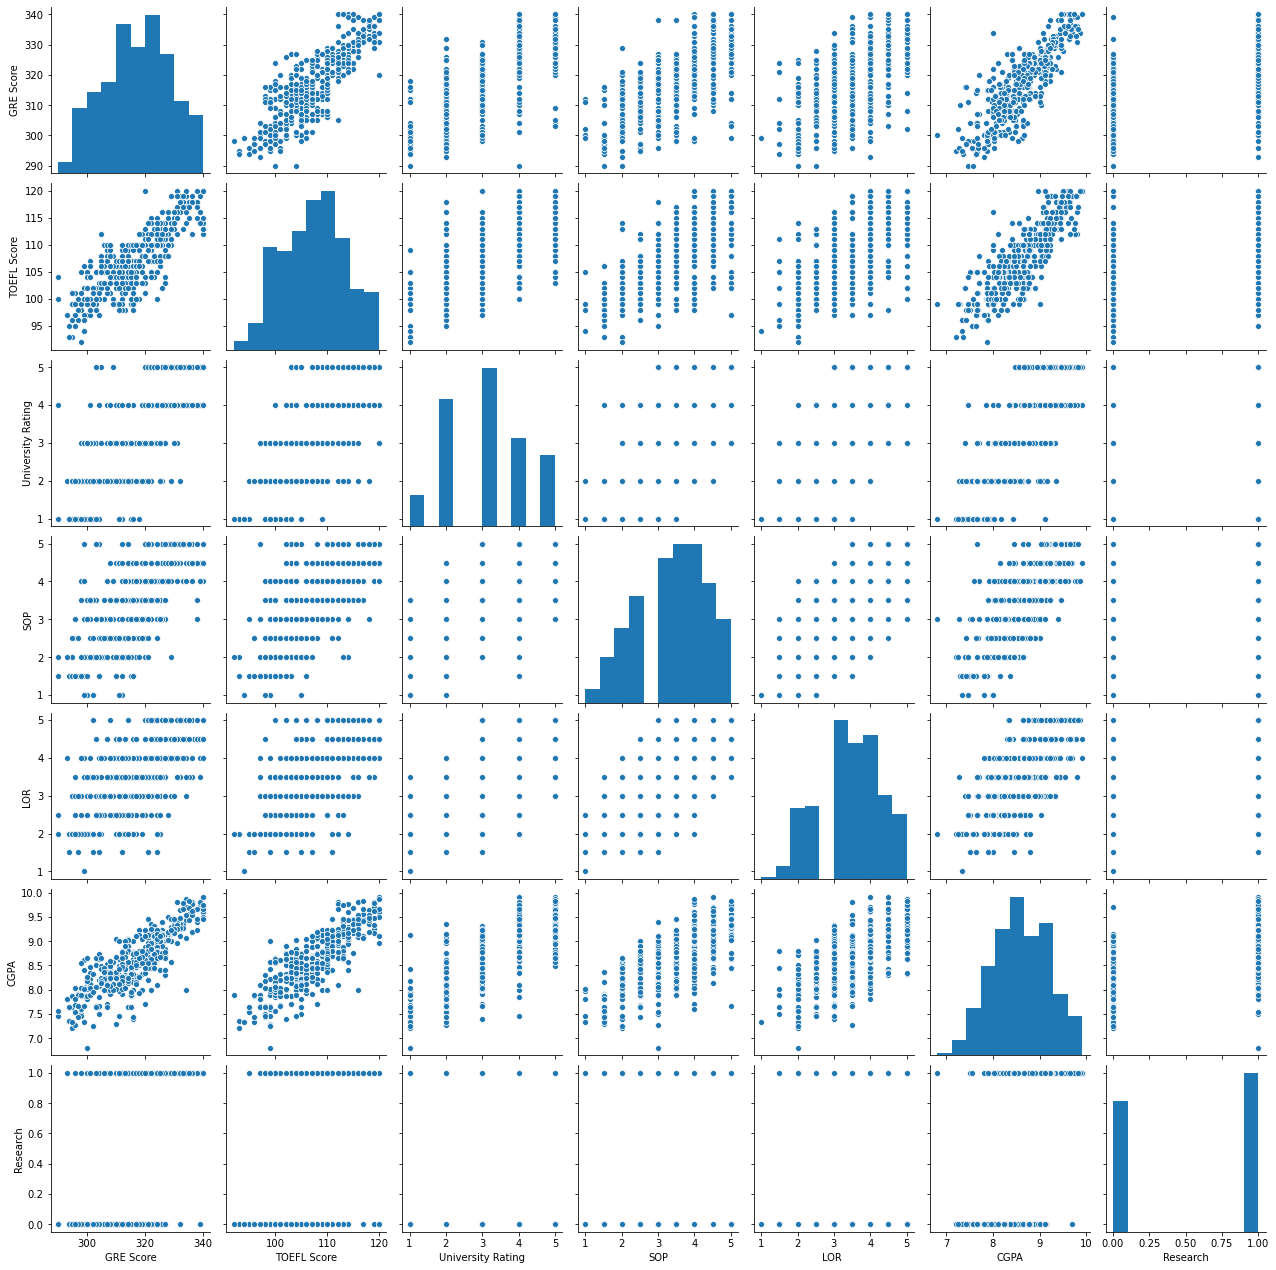

In [31]:
sns.pairplot(df.drop(columns=['Chance of Admit ']))

In [32]:
df.drop(columns=['Chance of Admit ']).corr()

,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research
GRE Score,1.000000,0.835977,0.668976,0.612831,0.557555,0.833060,0.580391
TOEFL Score,0.835977,1.000000,0.695590,0.657981,0.567721,0.828417,0.489858
University Rating,0.668976,0.695590,1.000000,0.734523,0.660123,0.746479,0.447783
SOP,0.612831,0.657981,0.734523,1.000000,0.729593,0.718144,0.444029
LOR,0.557555,0.567721,0.660123,0.729593,1.000000,0.670211,0.396859
CGPA,0.833060,0.828417,0.746479,0.718144,0.670211,1.000000,0.521654
Research,0.580391,0.489858,0.447783,0.444029,0.396859,0.521654,1.000000


In [33]:
df.corr()['Chance of Admit ']

GRE Score            0.802610
TOEFL Score          0.791594
University Rating    0.711250
SOP                  0.675732
LOR                  0.669889
CGPA                 0.873289
Research             0.553202
Chance of Admit      1.000000
Name: Chance of Admit , dtype: float64

In [141]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import LabelBinarizer, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV

In [35]:
df['University Rating'].unique()

array([4, 3, 2, 5, 1])

In [36]:
df['Research'].unique()

array([1, 0])

In [113]:
X_train, X_test, y_train, y_test = train_test_split(
    df.drop(columns='Chance of Admit '),
    df['Chance of Admit '],
    test_size=0.2,
    random_state=10
)

In [114]:
print(X_train.shape)
print(y_train.shape)

(320, 7)
(320,)


In [37]:
#Create a custom transformer that does the following
#OHE for University Rating and Research

In [87]:
#input pandas DataFrame, not numpy ndarray
#output is numpy ndarray
class InitialTransformation(BaseEstimator, TransformerMixin):
    def __init__(self, ohe_attr):
        self.ohe_attr = ohe_attr
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        oh_encoder = LabelBinarizer()
        oh_attr = []
        for i in X[self.ohe_attr].columns:
            oh_attr.append(oh_encoder.fit_transform(X[i]))
        return np.concatenate([X.drop(columns=self.ohe_attr).values, np.concatenate(oh_attr, axis=1)], axis=1)

In [147]:
#test the transformer
init_transformer = InitialTransformation(['University Rating'])
aaa = init_transformer.fit_transform(X_train)
aaa.shape

(320, 11)

In [148]:
#Use StandardScaler to scale all values for linear regression
scaler = StandardScaler()

In [149]:
#test scaler on custom transformer output
aa = scaler.fit_transform(aaa)
print(aa.shape)
aa[:1]

(320, 11)


array([[ 0.58772699, -0.02912599,  0.13744801,  0.07907984, -0.0587481 ,
         0.91601335, -0.25819889, -0.61105692,  1.3721818 , -0.46554273,
        -0.40451992]])

In [156]:
#make a pipeline for transformation
from sklearn.pipeline import Pipeline

data_transform = Pipeline([
    ('custom', InitialTransformation(['University Rating'])),
    ('scaler', StandardScaler())
])

In [157]:
#test the pipeline
bbb = data_transform.fit_transform(X_train)
bbb.shape

(320, 11)

In [92]:
#Plot the learning curve to check if at the basic state the data is under or over fitting

In [138]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error

In [179]:
def plot_learning_curve(df, model):
    X_train, X_test, y_train, y_test = train_test_split(
        df.drop(columns='Chance of Admit '),
        df['Chance of Admit '],
        test_size=0.2,
        random_state=73
    )
    X_train_tr = data_transform.fit_transform(X_train)
    X_test_tr = data_transform.fit_transform(X_test)
    train_errors = []
    test_errors = []
    for i in range(1, len(X_train_tr)):
        linreg = model.fit(X_train_tr[:i], y_train[:i])
        y_train_preds = linreg.predict(X_train_tr[:i])
        y_preds = linreg.predict(X_test_tr)
        train_errors.append(mean_squared_error(y_train[:i], y_train_preds, squared=False))
        test_errors.append(mean_squared_error(y_test, y_preds, squared=False))
    plt.figure(figsize=(12,8))
    plt.plot(np.arange(len(X_train_tr)-1), train_errors, label='Training error')
    plt.plot(np.arange(len(X_train_tr)-1), test_errors, label='Testing error')
    plt.legend()

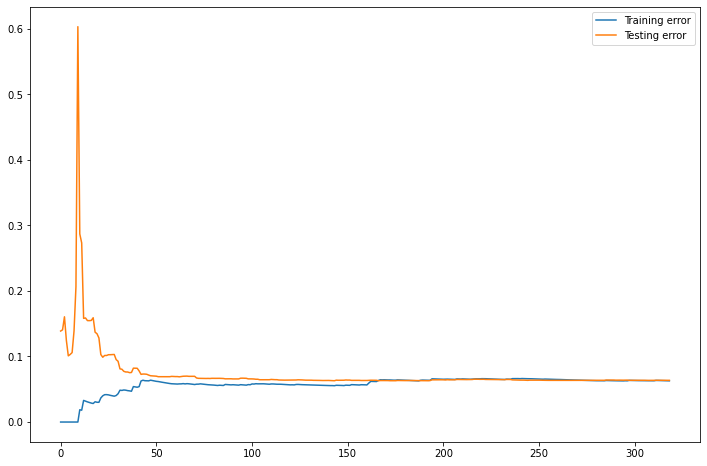

In [180]:
plot_learning_curve(df, LinearRegression())

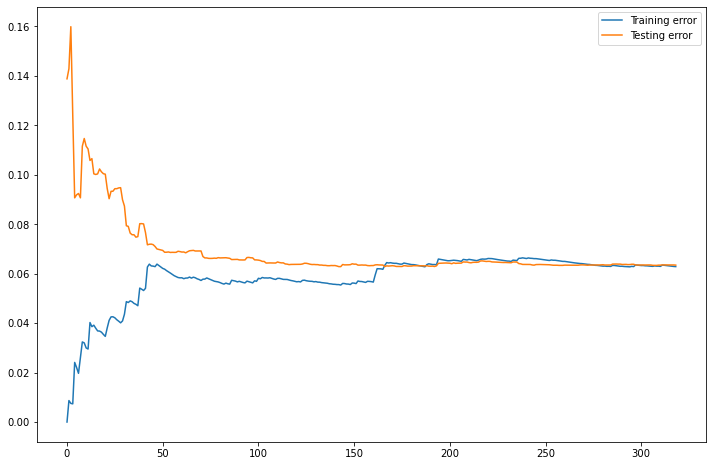

In [181]:
plot_learning_curve(df, Ridge())

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  positive)


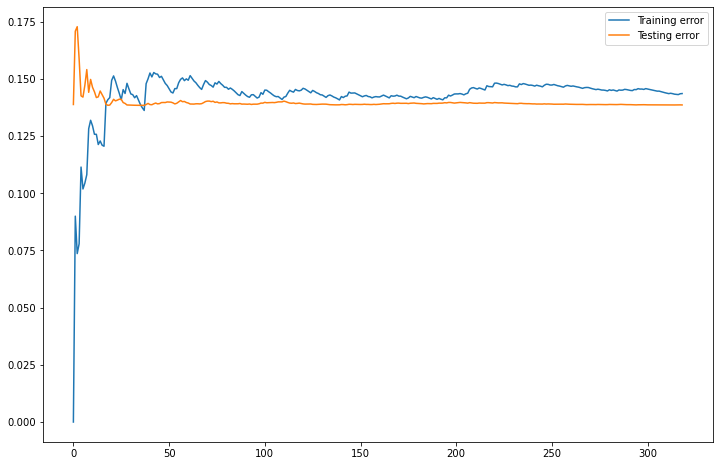

In [182]:
plot_learning_curve(df, Lasso())

In [140]:
#Use Ridge
#Use GridSearchCV to find alpha and other hyperparameters

In [174]:
X_train_prepped = data_transform.fit_transform(X_train)
X_test_prepped = data_transform.fit_transform(X_test)

In [175]:
param_grid = {
    'alpha': [0.001, 0.01, 0.1, 1, 10, 100],
    'solver': ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga']
}

In [183]:
grid_search = GridSearchCV(
    Ridge(),
    param_grid,
    scoring='neg_root_mean_squared_error'
).fit(X_train_prepped, y_train)

In [190]:
pd.DataFrame(grid_search.cv_results_).sort_values(by='rank_test_score')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,param_solver,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
33,0.002134,0.000161,0.000567,0.000014,10,sag,"{'alpha': 10, 'solver': 'sag'}",-0.065427,-0.057864,-0.070710,-0.061860,-0.069080,-0.064988,0.004695,1
28,0.001133,0.000044,0.000548,0.000025,10,auto,"{'alpha': 10, 'solver': 'auto'}",-0.065431,-0.057858,-0.070724,-0.061863,-0.069089,-0.064993,0.004702,2
30,0.001117,0.000013,0.000550,0.000021,10,cholesky,"{'alpha': 10, 'solver': 'cholesky'}",-0.065431,-0.057858,-0.070724,-0.061863,-0.069089,-0.064993,0.004702,2
29,0.001190,0.000058,0.000582,0.000023,10,svd,"{'alpha': 10, 'solver': 'svd'}",-0.065431,-0.057858,-0.070724,-0.061863,-0.069089,-0.064993,0.004702,2
34,0.001727,0.000153,0.000561,0.000024,10,saga,"{'alpha': 10, 'solver': 'saga'}",-0.065429,-0.057864,-0.070736,-0.061859,-0.069085,-0.064994,0.004702,5
31,0.002486,0.000112,0.000607,0.000035,10,lsqr,"{'alpha': 10, 'solver': 'lsqr'}",-0.065473,-0.057840,-0.070688,-0.061904,-0.069146,-0.065010,0.004704,6
26,0.002326,0.000062,0.000583,0.000021,1,sag,"{'alpha': 1, 'solver': 'sag'}",-0.065696,-0.057732,-0.071181,-0.062355,-0.068133,-0.065019,0.004655,7
32,0.002173,0.000066,0.000581,0.000017,10,sparse_cg,"{'alpha': 10, 'solver': 'sparse_cg'}",-0.065473,-0.057886,-0.070688,-0.061904,-0.069146,-0.065019,0.004690,8
22,0.001119,0.000027,0.000519,0.000016,1,svd,"{'alpha': 1, 'solver': 'svd'}",-0.065693,-0.057746,-0.071172,-0.062369,-0.068137,-0.065024,0.004646,9
21,0.001073,0.000050,0.000508,0.000016,1,auto,"{'alpha': 1, 'solver': 'auto'}",-0.065693,-0.057746,-0.071172,-0.062369,-0.068137,-0.065024,0.004646,10


In [211]:
cols = [i for i in X_train.columns if i != 'University Rating']
for i in range(1,6):
    cols.append('UR_{}'.format(i))

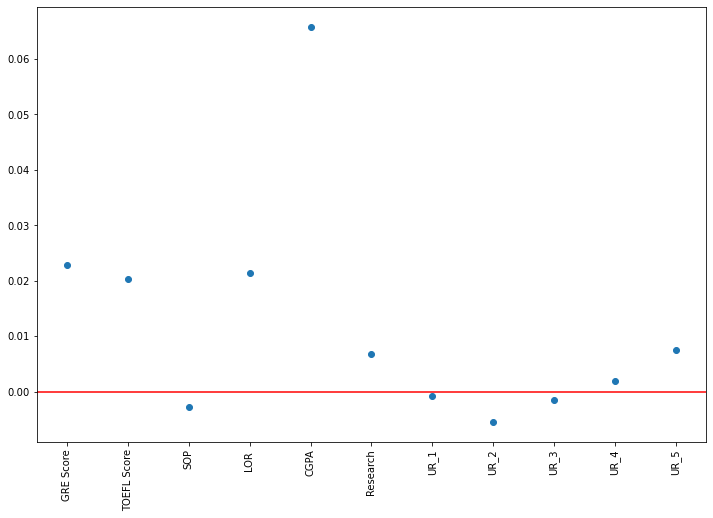

In [218]:
plt.figure(figsize=(12,8))
plt.scatter(cols, grid_search.best_estimator_.coef_)
plt.axhline(0, color='r')
plt.xticks(rotation=90)
plt.show()

In [233]:
print("Training RMSE: {}".format(grid_search.best_score_))
print("Testing RMSE: -{}".format(mean_squared_error(y_test, grid_search.best_estimator_.predict(X_test_prepped), squared=False)))

Training RMSE: -0.06498822036516705
Testing RMSE: -0.06572756468346695


In [220]:
#Remove University Rating and SOP
#For the same estimator, find RMSE
#Compare best estimator RMSE with feature removed RMSE

In [222]:
gs_resultant = grid_search.best_estimator_

In [225]:
X_train_short = X_train.drop(columns=['University Rating', 'SOP'])
X_test_short = X_test.drop(columns=['University Rating', 'SOP'])

In [234]:
X_train_short_scaled = scaler.fit_transform(X_train_short)
X_test_short_scaled = scaler.fit_transform(X_test_short)

In [236]:
gs_ridge_red_feat = gs_resultant.fit(X_train_short_scaled, y_train)

In [239]:
print("Training error with reduced features on the GridSearchCV best model: -{}".format(mean_squared_error(y_train, gs_ridge_red_feat.predict(X_train_short_scaled), squared=False)))
print("Testing error with reduced features on the GridSearchCV best model: -{}".format(mean_squared_error(y_test, gs_ridge_red_feat.predict(X_test_short_scaled), squared=False)))

Training error with reduced features on the GridSearchCV best model: -0.06296352310091784
Testing error with reduced features on the GridSearchCV best model: -0.06592707165225395


In [240]:
grid_search_cull = GridSearchCV(
    Ridge(),
    param_grid,
    scoring='neg_root_mean_squared_error'
).fit(X_train_short_scaled, y_train)

In [241]:
pd.DataFrame(grid_search_cull.cv_results_).sort_values(by='rank_test_score')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,param_solver,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
26,0.001568,0.000087,0.000538,0.000021,1,sag,"{'alpha': 1, 'solver': 'sag'}",-0.065516,-0.057291,-0.069568,-0.061377,-0.065927,-0.063936,0.004216,1
24,0.001755,0.000088,0.000534,0.000008,1,lsqr,"{'alpha': 1, 'solver': 'lsqr'}",-0.065512,-0.057312,-0.069615,-0.061371,-0.065898,-0.063942,0.004220,2
5,0.001715,0.000222,0.000523,0.000015,0.001,sag,"{'alpha': 0.001, 'solver': 'sag'}",-0.065580,-0.057268,-0.069703,-0.061352,-0.065806,-0.063942,0.004257,3
17,0.001760,0.000061,0.000529,0.000013,0.1,lsqr,"{'alpha': 0.1, 'solver': 'lsqr'}",-0.065575,-0.057279,-0.069703,-0.061352,-0.065805,-0.063943,0.004253,4
10,0.001714,0.000088,0.000525,0.000017,0.01,lsqr,"{'alpha': 0.01, 'solver': 'lsqr'}",-0.065581,-0.057276,-0.069712,-0.061350,-0.065796,-0.063943,0.004256,5
3,0.001826,0.000256,0.000528,0.000019,0.001,lsqr,"{'alpha': 0.001, 'solver': 'lsqr'}",-0.065582,-0.057275,-0.069713,-0.061350,-0.065795,-0.063943,0.004257,6
20,0.001363,0.000023,0.000519,0.000011,0.1,saga,"{'alpha': 0.1, 'solver': 'saga'}",-0.065574,-0.057278,-0.069687,-0.061352,-0.065829,-0.063944,0.004251,7
22,0.001086,0.000093,0.000537,0.000054,1,svd,"{'alpha': 1, 'solver': 'svd'}",-0.065512,-0.057312,-0.069615,-0.061371,-0.065920,-0.063946,0.004222,8
21,0.001058,0.000043,0.000515,0.000021,1,auto,"{'alpha': 1, 'solver': 'auto'}",-0.065512,-0.057312,-0.069615,-0.061371,-0.065920,-0.063946,0.004222,8
23,0.001066,0.000020,0.000536,0.000030,1,cholesky,"{'alpha': 1, 'solver': 'cholesky'}",-0.065512,-0.057312,-0.069615,-0.061371,-0.065920,-0.063946,0.004222,8


In [245]:
grid_search_cull.best_estimator_.coef_

array([0.02169177, 0.01939768, 0.02142787, 0.07431038, 0.00667027])

In [246]:
mean_squared_error(y_test, grid_search_cull.best_estimator_.predict(X_test_short_scaled), squared=False)

0.06643826303802731

In [252]:
#use fewer features model. i.e. X_train_short
#use the model from the first grid search survey that produced the lowest training RMSE: gs_ridge_red_feat
#run it in the validation set

In [251]:
val_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 400 to 499
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   GRE Score          100 non-null    int64  
 1   TOEFL Score        100 non-null    int64  
 2   University Rating  100 non-null    int64  
 3   SOP                100 non-null    float64
 4   LOR                100 non-null    float64
 5   CGPA               100 non-null    float64
 6   Research           100 non-null    int64  
 7   Chance of Admit    100 non-null    float64
dtypes: float64(4), int64(4)
memory usage: 6.4 KB


In [254]:
y_val = val_set['Chance of Admit ']

In [255]:
X_val = val_set.drop(columns=['University Rating', 'SOP', 'Chance of Admit '])

In [259]:
X_val_scaled = scaler.fit_transform(X_val)

In [260]:
mean_squared_error(y_val, gs_ridge_red_feat.predict(X_val_scaled), squared=False)

array([[-1.06550801, -1.04412759, -0.6002065 , -0.42328111, -1.25064086],
       [-0.01244529, -0.21807728, -0.6002065 , -0.23268549, -1.25064086],
       [ 0.84915148,  0.44276296, -0.6002065 ,  0.72029261,  0.79959006],
       [ 1.42354933,  1.59923339, -0.10823396,  1.1808987 ,  0.79959006],
       [-0.39537718, -0.87891752, -1.09217905, -1.34449327,  0.79959006],
       [-1.25697395, -1.20933765, -0.6002065 , -1.64626967, -1.25064086],
       [ 0.65768553, -0.5484974 , -1.09217905, -0.74094047,  0.79959006],
       [-1.63990585, -1.04412759,  0.38373858, -0.85212125,  0.79959006],
       [-1.73563883, -0.87891752,  0.38373858, -1.29684437,  0.79959006],
       [-1.4484399 , -1.37454771, -1.09217905, -0.74094047, -1.25064086],
       [-1.35270693, -1.70496783,  0.38373858, -1.47155702, -1.25064086],
       [-0.20391124, -2.03538795, -2.07612413, -0.56622782, -1.25064086],
       [-0.10817826, -0.71370746, -1.58415159, -0.96330203,  0.79959006],
       [ 0.17902066, -0.87891752, -1.5